## Bayesian Estimation Supersedes the T-Test
https://docs.pymc.io/notebooks/BEST.html

In [15]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.5


### 目的：drugとplaceboに差があるか知りたい(実際に効果があるか検証したい)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1188455c0>,
      dtype=object)

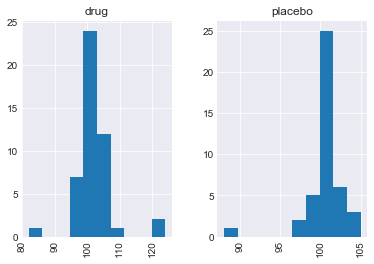

In [3]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group')

今回、これらの分布がスチューデントt分布に従うと仮定する。  
スチューデントt分布は通常の正規分布と比較してより外れ値にロバストである。

この時、νは二つの分布の間で共通だと仮定する

$$y^{(treat)}_i∼{\it T}(\nu,\mu_1,\sigma_1)$$
$$y^{(placebo)}_i∼{\it T}(\nu,\mu_2,\sigma_2)$$

In [4]:
# 事前分布として、group 1も 2も平均は全体の平均・分散に等しい正規分布に従うと仮定する
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', μ_m, sd=μ_s)

In [5]:
# 事前分布の分散は一様分布を仮定
σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

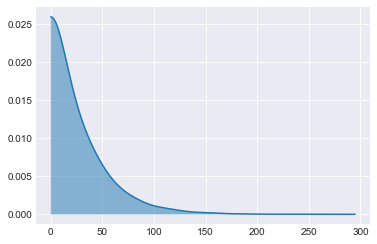

In [6]:
#  νは共通のハイパーパラメータ
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), shade=0.5)

In [7]:
# group1, 2のスチューデントt分布を定義
with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [8]:
# 平均・分散の差とeffect sizeを見てみる
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

In [9]:
# MCMC
with model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1379.03draws/s]


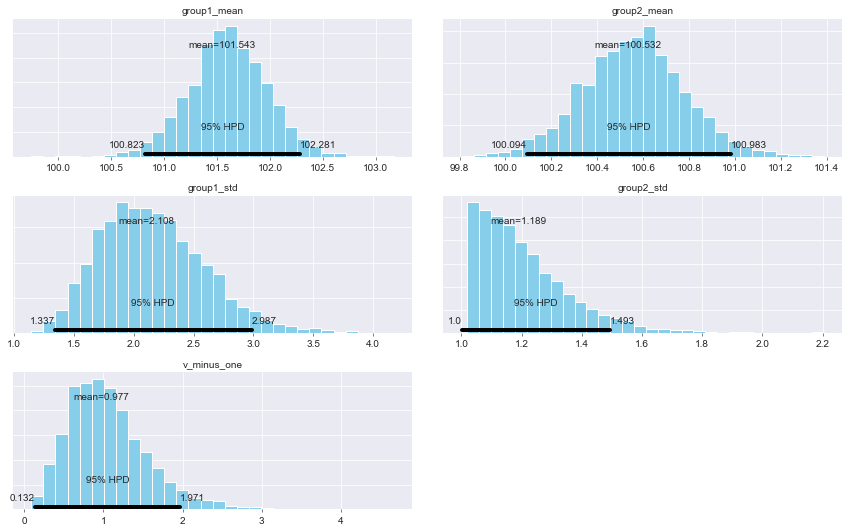

In [19]:
# 事後分布をプロット
pm.plot_posterior(trace, varnames=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb')
plt.show()

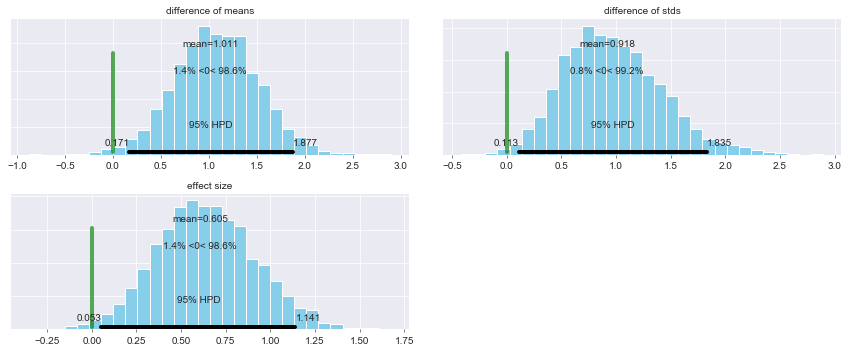

In [20]:
pm.plot_posterior(trace, varnames=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')
plt.show()

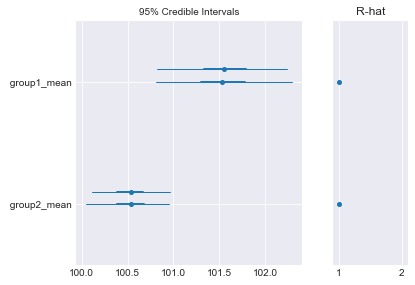

In [12]:
pm.forestplot(trace, varnames=['group1_mean',
                               'group2_mean'])

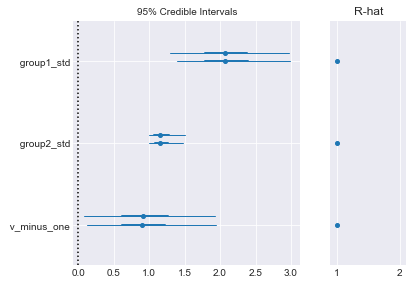

In [13]:
pm.forestplot(trace, varnames=['group1_std',
                               'group2_std',
                               'ν_minus_one'])

In [14]:
pm.summary(trace,varnames=['difference of means', 'difference of stds', 'effect size'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
difference of means,1.011189,0.438671,0.007970,0.171054,1.876686,3377.963001,1.000077
difference of stds,0.918433,0.449503,0.007278,0.112689,1.834570,3578.602677,0.999776
effect size,0.605098,0.277431,0.004738,0.052952,1.140527,3846.735612,0.999905


In [24]:
# 二群間の平均が異なる確率
np.mean(trace['difference of means'] > 0)

0.986

In [25]:
# 二群間の分散が異なる確率
np.mean(trace['difference of stds'] > 0)

0.9925